In [1]:
import numpy as np
import pandas as pd
import sys
import os
import shutil
from sklearn.metrics import silhouette_score

<h2>데이터 전처리<h2>

In [2]:
def read_text_files_to_dataframe(folder_path):
    
    latitude = []
    longitude = []
    date = []
    time = []

    # 폴더 내의 모든 텍스트 파일을 읽음
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            
            # 텍스트 파일을 DataFrame에 추가

            with open(file_path, 'r') as file:
                data = file.read()

            data = data.split('\n')[6:-1]
            for i in range(len(data)):
                line = data[i].split(',')
                latitude.append(line[0])
                longitude.append(line[1])
                date.append(line[5])
                time.append(line[6])

    df = pd.DataFrame({"latitude":latitude, "longitude":longitude, "date":date, "time":time})
    df['latitude'] = df['latitude'].astype(float)
    df['longitude'] = df['longitude'].astype(float)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S')
    df['datetime'] = df['datetime'].dt.floor('T')
    df = df.drop(['date', 'time'], axis=1)
    df = df.drop_duplicates(['datetime'], ignore_index=True)

    return df

In [3]:
folder_path = "C:\\Users\\sk002\\OneDrive\\바탕 화면\\학교\\Yoodori\\Geolife Trajectories 1.3\\Data\\000\\Trajectory"

dataframe = read_text_files_to_dataframe(folder_path)

dataframe

,latitude,longitude,datetime
0,39.984702,116.318417,2008-10-23 02:53:00
1,39.984586,116.316716,2008-10-23 02:54:00
2,39.984485,116.314426,2008-10-23 02:55:00
3,39.984696,116.312921,2008-10-23 02:56:00
4,39.984656,116.310660,2008-10-23 02:57:00
...,...,...,...
15118,39.996230,116.326576,2009-07-05 07:41:00
15119,39.999069,116.328971,2009-07-05 07:42:00
15120,39.999975,116.327367,2009-07-05 07:43:00
15121,39.999974,116.327326,2009-07-05 07:44:00


<h2>의미장소 추출<h2>

In [4]:
from pyclustering.cluster.gmeans import gmeans
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster import cluster_visualizer_multidim
import folium

In [17]:
def gmeans_(df):
    # 두 열을 선택하고 넘파이 배열로 변환
    selected_columns = ['latitude', 'longitude']
    result_list = df[selected_columns].values.tolist()
    
    gmeans_instance = gmeans(result_list).process()

    # Extract clustering results: clusters and their centers
    clusters = gmeans_instance.get_clusters()
    centers = gmeans_instance.get_centers()

    return clusters, centers
    

In [6]:
def map(centers, i):

    # 예제 데이터 생성 (서울의 위도, 경도)
    locations = centers

    # 지도의 중심 좌표 설정
    map_center = [sum(x[0] for x in locations) / len(locations), sum(x[1] for x in locations) / len(locations)]

    # Folium 맵 생성
    mymap = folium.Map(location=map_center, zoom_start=12)

    # 위치 데이터를 지도에 마커로 표시
    for loc in locations:
        folium.Marker(location=loc, popup='Location').add_to(mymap)

    # 지도를 HTML 파일로 저장하거나 주피터 노트북에서 바로 표시
    file_name = f'map{i}.html'
    mymap.save(file_name)


In [7]:
def fileReader(folder_path, filename):
    latitude = []
    longitude = []
    date = []
    time = []
    file_path = os.path.join(folder_path, filename)
            
    # 텍스트 파일을 DataFrame에 추가

    with open(file_path, 'r') as file: 
        data = file.read()

    data = data.split('\n')[6:-1]
    for i in range(len(data)):
        line = data[i].split(',')
        latitude.append(line[0])
        longitude.append(line[1])
        date.append(line[5])
        time.append(line[6])

    df = pd.DataFrame({"latitude":latitude, "longitude":longitude, "date":date, "time":time})

    return df

In [8]:
def app(folder_path):
    
    j = 0
    data_dict = {}
    # 폴더 내의 모든 텍스트 파일을 읽음
    for filename in os.listdir(folder_path):

        df = fileReader(folder_path, filename)

        df['latitude'] = df['latitude'].astype(float)
        df['longitude'] = df['longitude'].astype(float)
        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S')
        df['datetime'] = df['datetime'].dt.floor('T')
        df = df.drop(['date', 'time'], axis=1)
        df = df.drop_duplicates(['datetime'], ignore_index=True)

        clusters, centers = gmeans(df)

        data_dict[j] = pd.DataFrame({"clusters":clusters, "centers":centers})
        
        for k in range(len(data_dict[j].clusters)):
            if (len(data_dict[j].clusters[k]) < 6):
                data_dict[j].drop(index=k, inplace=True)
        data_dict[j] = data_dict[j].sort_index(axis=1)

        map(centers, j)
        
        j += 1
    return data_dict

In [9]:
#folder_name = r'C:\Users\sk002\OneDrive\바탕 화면\학교\Yoodori\Geolife Trajectories 1.3\Data\000\Trajectory'
#data_dict = app(folder_name)

In [18]:
def fileReader(filename):

    latitude = []   # 위도
    longitude = []  # 경도
    date = []       # 날짜
    time = []       # 시간

    with open(filename, 'r') as file:
        data = file.read()

    # 데이터에 불필요한 부분 제거
    # 추후 데이터 형식에 따라 수정 필요 *
    data = data.split('\n')[6:-1]
    for i in range(len(data)):
        line = data[i].split(',')
        latitude.append(line[0])    # 위도
        longitude.append(line[1])   # 경도
        date.append(line[5])        # 날짜
        time.append(line[6])        # 시간

    df = pd.DataFrame({"latitude":latitude, "longitude":longitude, "date":date, "time":time})

    return df

In [19]:
def gmeansFit(df):
    # 두 열을 선택하고 넘파이 배열로 변환
    selectedColumns = ['latitude', 'longitude']
    resultList = df[selectedColumns].values.tolist()    # 리스트로 변환
    
    gmeansInstance = gmeans(resultList).process()       # 클러스터링

    centers = gmeansInstance.get_centers()              # 클러스터의 중심 (의미장소)
    clusters = gmeansInstance.get_clusters()            # 분류된 클러스터


    return clusters, centers

In [20]:
def gmeansFunc(file_name):
    
    j = 0
    data_dict = {}

    df = fileReader(file_name)

    # 위도 경도 데이터 형식 변경
    df['latitude'] = df['latitude'].astype(float)
    df['longitude'] = df['longitude'].astype(float)
    # 날짜, 시간 데이터 병합
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S')
    df['datetime'] = df['datetime'].dt.floor('T')
    df = df.drop(['date', 'time'], axis=1)
    # 1분 단위로 데이터 병합
    df = df.drop_duplicates(['datetime'], ignore_index=True)

    # 의미장소 추출
    clusters, centers = gmeansFit(df)
        
    # 딕셔너리 형식으로 데이터 저장
    data_dict[j] = pd.DataFrame({"clusters":clusters, "centers":centers})
        
    # 클러스터가 10개 미만인 의미장소 제거
    for k in range(len(data_dict[j].clusters)):
        if (len(data_dict[j].clusters[k]) < 10):
            data_dict[j].drop(index=k, inplace=True)
    data_dict[j] = data_dict[j].sort_index(axis=1)
        
    j += 1
    return data_dict

In [21]:
file_name = r'C:\Users\sk002\OneDrive\바탕 화면\학교\Yoodori\Geolife Trajectories 1.3\Data\000\Trajectory\20090403011657.txt'
data_dict = gmeansFunc(file_name)

TypeError: list indices must be integers or slices, not list

<h2>서버에 올릴 코드<h2>

In [2]:
from pyclustering.cluster.gmeans import gmeans
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster import cluster_visualizer_multidim
import numpy as np
import pandas as pd
import os
import folium

In [3]:
def fileReader(filename):

    latitude = []   # 위도
    longitude = []  # 경도
    date = []       # 날짜
    time = []       # 시간

    with open(filename, 'r') as file:
        data = file.read()

    # 데이터에 불필요한 부분 제거
    # 추후 데이터 형식에 따라 수정 필요 *
    data = data.split('\n')[6:-1]
    for i in range(len(data)):
        line = data[i].split(',')
        latitude.append(line[0])    # 위도
        longitude.append(line[1])   # 경도
        date.append(line[5])        # 날짜
        time.append(line[6])        # 시간

    df = pd.DataFrame({"latitude":latitude, "longitude":longitude, "date":date, "time":time})

    
    df['latitude'] = df['latitude'].astype(float)
    df['longitude'] = df['longitude'].astype(float)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S')
    df['datetime'] = df['datetime'].dt.floor('T')
    df = df.drop(['date', 'time'], axis=1)
    df = df.drop_duplicates(['datetime'], ignore_index=True)

    return df

In [4]:
# 의미장소 추출
def gmeansFit(df):
    # 두 열을 선택하고 넘파이 배열로 변환
    selectedColumns = ['latitude', 'longitude']
    resultList = df[selectedColumns].values.tolist()    # 리스트로 변환
    
    gmeansInstance = gmeans(resultList).process()       # 클러스터링

    centers = gmeansInstance.get_centers()              # 클러스터의 중심 (의미장소)
    clusters = gmeansInstance.get_clusters()            # 분류된 클러스터


    return clusters, centers

In [17]:
def gmeansFunc(df):


    clusters, centers = gmeansFit(df)

    data_df = pd.DataFrame({"clusters":clusters, "centers":centers})
        
    for k in range(len(data_df.clusters)):
        if (len(data_df.clusters[k]) < 10):
            data_df.drop(index=k, inplace=True)
    data_df = data_df.sort_index(axis=1)
    data_df = data_df.reset_index(drop=True)
    
    result = data_df.centers.values.tolist()

    return data_df

In [18]:
file_name = r'C:\Users\sk002\OneDrive\바탕 화면\학교\Yoodori\Geolife Trajectories 1.3\Data\003\Trajectory\20090403011657.txt'
df1 = fileReader(file_name)
data_df_1 = gmeansFunc(df1)

In [19]:
file_name = r'C:\Users\sk002\OneDrive\바탕 화면\학교\Yoodori\Geolife Trajectories 1.3\Data\003\Trajectory\20090120002837.txt'
df2 = fileReader(file_name)
data_df_2 = gmeansFunc(df2)

In [20]:
file_name = r'C:\Users\sk002\OneDrive\바탕 화면\학교\Yoodori\Geolife Trajectories 1.3\Data\003\Trajectory\20090221034838.txt'
df3 = fileReader(file_name)
data_df_3 = gmeansFunc(df3)

In [21]:
file_name = r'C:\Users\sk002\OneDrive\바탕 화면\학교\Yoodori\Geolife Trajectories 1.3\Data\003\Trajectory\20090214045230.txt'
df4 = fileReader(file_name)
data_df_4 = gmeansFunc(df4)

In [22]:
file_name = r'C:\Users\sk002\OneDrive\바탕 화면\학교\Yoodori\Geolife Trajectories 1.3\Data\003\Trajectory\20081202160051.txt'
df5 = fileReader(file_name)
data_df_5 = gmeansFunc(df5)

In [23]:
data_df_1

,centers,clusters
0,"[39.9966634, 116.27590759999998]","[861, 862, 863, 864, 865, 866, 867, 868, 869, ..."
1,"[39.99657862499999, 116.27305329166666]","[871, 872, 873, 874, 875, 876, 919, 920, 921, ..."
2,"[39.992524374999995, 116.27430650000001]","[877, 878, 879, 880, 881, 882, 883, 884, 911, ..."
3,"[39.989553500000014, 116.27197426923075]","[885, 886, 887, 888, 889, 890, 891, 892, 893, ..."
4,"[39.99600499999999, 116.29029709999998]","[849, 850, 851, 852, 853, 854, 855, 856, 992, ..."
5,"[40.00982324324324, 116.31508710810809]","[47, 237, 242, 248, 250, 387, 398, 415, 455, 4..."
6,"[40.00993709090909, 116.31520168181822]","[38, 45, 46, 309, 330, 342, 370, 413, 534, 692..."
7,"[40.00999254166666, 116.31492337499999]","[36, 37, 48, 49, 213, 214, 215, 239, 310, 388,..."
8,"[40.009686795918356, 116.31502740816327]","[218, 238, 322, 378, 379, 394, 395, 401, 409, ..."
9,"[40.00956615999999, 116.31517384]","[227, 230, 246, 340, 390, 406, 411, 412, 419, ..."


In [24]:
data_df_2

,centers,clusters
0,"[33.55559185714285, 119.70179814285713]","[685, 686, 687, 688, 689, 690, 691, 692, 693, ..."
1,"[32.0172753, 120.83047619999999]","[857, 858, 859, 860, 861, 862, 863, 864, 865, ..."
2,"[32.07005584210527, 120.85438831578946]","[818, 819, 820, 821, 822, 823, 824, 825, 826, ..."
3,"[34.1647111904762, 118.70941452380951]","[600, 601, 602, 603, 604, 605, 606, 607, 608, ..."
4,"[34.35860088000001, 118.38388452000001]","[575, 576, 577, 578, 579, 580, 581, 582, 583, ..."
5,"[33.54338811764706, 119.3318145882353]","[668, 669, 670, 671, 672, 673, 674, 675, 676, ..."
6,"[33.6336987037037, 119.04485937037038]","[641, 642, 643, 644, 645, 646, 647, 648, 649, ..."
7,"[33.886386949999995, 118.88300544999997]","[621, 622, 623, 624, 625, 626, 627, 628, 629, ..."
8,"[34.2645017, 117.20207580000002]","[509, 510, 511, 512, 513, 514, 515, 516, 517, ..."
9,"[39.901377761904754, 116.4237179047619]","[138, 139, 140, 141, 142, 143, 144, 145, 146, ..."


In [25]:
data_df_3

,centers,clusters
0,"[40.00884143478261, 116.32202982608699]","[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3..."
1,"[40.00514978947369, 116.32449673684208]","[24, 25, 26, 50, 51, 52, 53, 54, 55, 56, 57, 5..."
2,"[39.994915636363636, 116.32700609090911]","[15, 16, 17, 18, 19, 79, 80, 81, 82, 83, 84]"
3,"[39.99241869230769, 116.33367292307693]","[96, 308, 309, 310, 311, 312, 313, 314, 315, 3..."
4,"[39.99159147058823, 116.33125102941176]","[85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 9..."
5,"[40.000713941176464, 116.32517311764707]","[20, 21, 22, 23, 66, 67, 68, 69, 70, 71, 72, 7..."
6,"[39.999136593749995, 116.33848184374999]","[338, 372, 390, 391, 393, 407, 409, 410, 411, ..."
7,"[39.99924691666667, 116.33840529166666]","[337, 346, 347, 353, 354, 358, 360, 370, 371, ..."
8,"[39.99929078571428, 116.33853817857143]","[404, 416, 419, 441, 442, 500, 505, 506, 507, ..."
9,"[39.999031249999994, 116.33843549999999]","[342, 348, 352, 355, 359, 361, 373, 374, 388, ..."


In [26]:
data_df_4

,centers,clusters
0,"[39.9920081, 116.333824]","[7, 8, 166, 167, 168, 169, 170, 171, 172, 173]"
1,"[39.991540923076926, 116.33187223076924]","[9, 10, 11, 12, 13, 14, 15, 112, 113, 114, 163..."
2,"[39.991499184210525, 116.32806649999999]","[118, 119, 120, 121, 122, 123, 124, 125, 126, ..."
3,"[39.99894810526316, 116.3386877368421]","[193, 201, 202, 214, 230, 240, 241, 254, 266, ..."
4,"[39.99892882692307, 116.33849058653844]","[182, 184, 188, 194, 200, 206, 212, 251, 280, ..."
5,"[39.99928745454547, 116.33876645454546]","[211, 220, 222, 246, 255, 256, 261, 268, 272, ..."
6,"[39.99917187850469, 116.3385010093458]","[185, 250, 253, 279, 284, 285, 293, 295, 302, ..."
7,"[39.998642960000005, 116.33839291999995]","[305, 306, 314, 331, 332, 500, 512, 519, 538, ..."
8,"[39.998827666666664, 116.33831326666669]","[195, 213, 310, 311, 312, 327, 379, 393, 482, ..."
9,"[39.998685232558145, 116.33855909302324]","[1, 183, 187, 189, 191, 192, 196, 205, 209, 22..."


In [27]:
data_df_5

,centers,clusters
0,"[39.941263, 116.36623705555556]","[581, 582, 583, 584, 585, 586, 587, 588, 589, ..."
1,"[39.909835684210535, 116.36781631578948]","[596, 597, 598, 599, 600, 601, 602, 603, 604, ..."
2,"[39.92483313333333, 116.36714866666668]","[590, 591, 592, 593, 594, 595, 615, 616, 617, ..."
3,"[39.960807625, 116.3645603125]","[574, 575, 576, 577, 578, 579, 580, 633, 634, ..."
4,"[39.93532388235295, 116.32208179411761]","[409, 418, 419, 420, 421, 422, 423, 424, 425, ..."
5,"[39.9348739, 116.3227672]","[407, 408, 410, 411, 412, 413, 414, 415, 416, ..."
6,"[39.93607088235294, 116.32129147058824]","[406, 450, 451, 452, 460, 461, 479, 480, 481, ..."
7,"[39.935868625000005, 116.31968258333335]","[453, 454, 455, 456, 457, 458, 459, 462, 463, ..."
8,"[39.99179409090909, 116.32650563636365]","[383, 384, 513, 527, 528, 529, 530, 533, 534, ..."
9,"[39.991274, 116.32932445454547]","[549, 550, 551, 552, 553, 554, 555, 556, 663, ..."


In [16]:
print(f'df1 : {len(df1)} | df2 : {len(df2)} | df3 : {len(df3)} | df4 : {len(df4)} | df5 : {len(df5)}')

df1 : 1171 | df2 : 944 | df3 : 716 | df4 : 760 | df5 : 685


In [83]:
df

,latitude,longitude,datetime
0,40.001520,116.311859,2009-04-03 01:16:00
1,40.001437,116.312250,2009-04-03 01:17:00
2,40.002051,116.312630,2009-04-03 01:18:00
3,40.004016,116.312476,2009-04-03 01:19:00
4,40.004578,116.314774,2009-04-03 01:20:00
...,...,...,...
1166,40.009642,116.315100,2009-04-04 14:31:00
1167,40.009683,116.315028,2009-04-04 14:32:00
1168,40.009551,116.315061,2009-04-04 14:33:00
1169,40.009591,116.315148,2009-04-04 14:34:00


In [29]:
df.iloc[1037]

latitude                 39.9098
longitude             116.404888
datetime     2009-04-04 12:04:00
Name: 1037, dtype: object

In [28]:
data_df.clusters.iloc[0][0]

1037

In [44]:
data_df

,centers,clusters
0,"[39.9097909090909, 116.40469272727273]","[1037, 1038, 1039, 1040, 1041, 1042, 1043, 104..."
1,"[39.89846146153847, 116.38943146153848]","[1075, 1076, 1077, 1078, 1079, 1080, 1081, 108..."
2,"[39.98576385, 116.41272174999999]","[89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 1..."
3,"[40.009614027027034, 116.31523137837836]","[39, 41, 42, 50, 223, 224, 231, 245, 348, 349,..."
4,"[40.00951454999999, 116.31530625]","[40, 228, 229, 376, 426, 433, 443, 450, 482, 5..."
5,"[40.0098346451613, 116.31509264516127]","[47, 242, 248, 250, 387, 415, 455, 462, 567, 5..."
6,"[40.00973762499999, 116.31511082499999]","[247, 317, 341, 382, 398, 428, 456, 509, 530, ..."
7,"[40.00993477272727, 116.3152046818182]","[38, 45, 46, 309, 330, 342, 370, 413, 534, 692..."
8,"[40.00968824242424, 116.31517781818182]","[244, 249, 316, 319, 325, 327, 329, 422, 423, ..."
9,"[40.00976213157895, 116.31521149999999]","[318, 337, 350, 351, 352, 353, 354, 355, 356, ..."


In [50]:
df['latitude'].iloc[1038]

39.909722

In [54]:
df['latitude'].iloc[0]

40.00152

In [28]:
df1['labels'] = -1
for cluster_idx, (cluster, center) in enumerate(zip(data_df_1.clusters, data_df_1.centers)):
    for point_idx in cluster:
        df1['labels'].iloc[point_idx] = cluster_idx
        
df1

C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\2373288560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['labels'].iloc[point_idx] = cluster_idx
C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\2373288560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['labels'].iloc[point_idx] = cluster_idx
C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\2373288560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['labels'].i

,latitude,longitude,datetime,labels
0,40.001520,116.311859,2009-04-03 01:16:00,-1
1,40.001437,116.312250,2009-04-03 01:17:00,-1
2,40.002051,116.312630,2009-04-03 01:18:00,-1
3,40.004016,116.312476,2009-04-03 01:19:00,-1
4,40.004578,116.314774,2009-04-03 01:20:00,-1
...,...,...,...,...
1166,40.009642,116.315100,2009-04-04 14:31:00,11
1167,40.009683,116.315028,2009-04-04 14:32:00,8
1168,40.009551,116.315061,2009-04-04 14:33:00,12
1169,40.009591,116.315148,2009-04-04 14:34:00,9


In [29]:
df2['labels'] = -1
for cluster_idx, (cluster, center) in enumerate(zip(data_df_2.clusters, data_df_2.centers)):
    for point_idx in cluster:
        df2['labels'].iloc[point_idx] = cluster_idx
        
df2

C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\1978855526.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['labels'].iloc[point_idx] = cluster_idx
C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\1978855526.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['labels'].iloc[point_idx] = cluster_idx
C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\1978855526.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['labels'].i

,latitude,longitude,datetime,labels
0,39.999840,116.327191,2009-01-20 00:28:00,-1
1,39.999991,116.326629,2009-01-20 00:29:00,-1
2,40.001186,116.325686,2009-01-20 00:30:00,-1
3,40.002164,116.324517,2009-01-20 00:31:00,-1
4,40.003486,116.323199,2009-01-20 00:32:00,-1
...,...,...,...,...
939,32.057004,121.270890,2009-01-21 02:11:00,-1
940,32.057173,121.269710,2009-01-21 02:16:00,-1
941,32.056679,121.271410,2009-01-21 02:17:00,-1
942,32.056826,121.271292,2009-01-21 02:18:00,-1


In [30]:
df3['labels'] = -1
for cluster_idx, (cluster, center) in enumerate(zip(data_df_3.clusters, data_df_3.centers)):
    for point_idx in cluster:
        df3['labels'].iloc[point_idx] = cluster_idx
        
df3

C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\3144256473.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['labels'].iloc[point_idx] = cluster_idx
C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\3144256473.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['labels'].iloc[point_idx] = cluster_idx
C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\3144256473.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['labels'].i

,latitude,longitude,datetime,labels
0,39.999168,116.334129,2009-02-21 03:48:00,-1
1,39.999380,116.334245,2009-02-21 03:49:00,-1
2,40.000569,116.333664,2009-02-21 03:50:00,-1
3,40.000496,116.333412,2009-02-21 03:51:00,-1
4,40.000529,116.332941,2009-02-21 03:52:00,-1
...,...,...,...,...
711,39.996333,116.338616,2009-02-21 22:52:00,-1
712,39.996465,116.338802,2009-02-21 22:53:00,-1
713,39.996531,116.338755,2009-02-21 22:54:00,-1
714,39.997935,116.338913,2009-02-21 22:55:00,20


In [31]:
df4['labels'] = -1
for cluster_idx, (cluster, center) in enumerate(zip(data_df_4.clusters, data_df_4.centers)):
    for point_idx in cluster:
        df4['labels'].iloc[point_idx] = cluster_idx
        
df4

C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\3299083749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['labels'].iloc[point_idx] = cluster_idx
C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\3299083749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['labels'].iloc[point_idx] = cluster_idx
C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\3299083749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['labels'].i

,latitude,longitude,datetime,labels
0,39.998569,116.339200,2009-02-14 04:52:00,10
1,39.998634,116.338622,2009-02-14 04:53:00,9
2,39.998102,116.337258,2009-02-14 04:54:00,-1
3,39.997688,116.334919,2009-02-14 04:55:00,-1
4,39.997469,116.333972,2009-02-14 04:56:00,-1
...,...,...,...,...
755,39.999533,116.338270,2009-02-14 23:35:00,15
756,39.998664,116.338281,2009-02-14 23:36:00,7
757,39.998998,116.337676,2009-02-14 23:37:00,-1
758,39.999212,116.338239,2009-02-14 23:38:00,-1


In [32]:
df5['labels'] = -1
for cluster_idx, (cluster, center) in enumerate(zip(data_df_5.clusters, data_df_5.centers)):
    for point_idx in cluster:
        df5['labels'].iloc[point_idx] = cluster_idx
        
df5

C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\2412946458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['labels'].iloc[point_idx] = cluster_idx
C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\2412946458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['labels'].iloc[point_idx] = cluster_idx
C:\Users\sk002\AppData\Local\Temp\ipykernel_3620\2412946458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['labels'].i

,latitude,longitude,datetime,labels
0,39.999869,116.326993,2008-12-02 16:00:00,21
1,39.999895,116.327039,2008-12-02 16:01:00,21
2,39.999880,116.325793,2008-12-02 16:02:00,21
3,40.000132,116.324713,2008-12-02 16:03:00,-1
4,40.001176,116.324511,2008-12-02 16:04:00,-1
...,...,...,...,...
680,39.996573,116.326611,2008-12-03 11:30:00,20
681,39.998787,116.326686,2008-12-03 11:31:00,21
682,39.999864,116.327365,2008-12-03 11:32:00,21
683,39.999924,116.327458,2008-12-03 11:33:00,21


In [33]:
for i in range(-1, max(df1['labels']) + 1):
    print(len(df1[df1['labels'] == i]))


373
10
24
16
26
10
37
22
24
49
25
20
47
16
18
39
16
31
53
34
19
28
24
15
11
19
13
12
34
12
13
14
20
13
11
10
13


<h2>클러스터링 2번<h2>

In [32]:
import folium

# 예제 데이터 생성 (서울의 위도, 경도)
locations = data_df_1.centers.values.tolist()

# 지도의 중심 좌표 설정
map_center = [sum(x[0] for x in locations) / len(locations), sum(x[1] for x in locations) / len(locations)]

# Folium 맵 생성
mymap = folium.Map(location=map_center, zoom_start=12)

# 위치 데이터를 지도에 마커로 표시
for loc in locations:
    folium.Marker(location=loc, popup='Location').add_to(mymap)

# 지도를 HTML 파일로 저장하거나 주피터 노트북에서 바로 표시
mymap


In [33]:
# 예제 데이터 생성 (서울의 위도, 경도)
locations = data_df_2.centers.values.tolist()

# 지도의 중심 좌표 설정
map_center = [sum(x[0] for x in locations) / len(locations), sum(x[1] for x in locations) / len(locations)]

# Folium 맵 생성
mymap = folium.Map(location=map_center, zoom_start=12)

# 위치 데이터를 지도에 마커로 표시
for loc in locations:
    folium.Marker(location=loc, popup='Location').add_to(mymap)

# 지도를 HTML 파일로 저장하거나 주피터 노트북에서 바로 표시
mymap

In [34]:
# 예제 데이터 생성 (서울의 위도, 경도)
locations = data_df_3.centers.values.tolist()

# 지도의 중심 좌표 설정
map_center = [sum(x[0] for x in locations) / len(locations), sum(x[1] for x in locations) / len(locations)]

# Folium 맵 생성
mymap = folium.Map(location=map_center, zoom_start=12)

# 위치 데이터를 지도에 마커로 표시
for loc in locations:
    folium.Marker(location=loc, popup='Location').add_to(mymap)

# 지도를 HTML 파일로 저장하거나 주피터 노트북에서 바로 표시
mymap

In [35]:
# 예제 데이터 생성 (서울의 위도, 경도)
locations = data_df_4.centers.values.tolist()

# 지도의 중심 좌표 설정
map_center = [sum(x[0] for x in locations) / len(locations), sum(x[1] for x in locations) / len(locations)]

# Folium 맵 생성
mymap = folium.Map(location=map_center, zoom_start=12)

# 위치 데이터를 지도에 마커로 표시
for loc in locations:
    folium.Marker(location=loc, popup='Location').add_to(mymap)

# 지도를 HTML 파일로 저장하거나 주피터 노트북에서 바로 표시
mymap

In [36]:
# 예제 데이터 생성 (서울의 위도, 경도)
locations = data_df_5.centers.values.tolist()

# 지도의 중심 좌표 설정
map_center = [sum(x[0] for x in locations) / len(locations), sum(x[1] for x in locations) / len(locations)]

# Folium 맵 생성
mymap = folium.Map(location=map_center, zoom_start=12)

# 위치 데이터를 지도에 마커로 표시
for loc in locations:
    folium.Marker(location=loc, popup='Location').add_to(mymap)

# 지도를 HTML 파일로 저장하거나 주피터 노트북에서 바로 표시
mymap

<h2>실루엣 계수<h2>

In [61]:
df.iloc[1038]

latitude               39.909722
longitude             116.404901
datetime     2009-04-04 12:05:00
labels                         0
Name: 1038, dtype: object

In [34]:
silhouette_avg = silhouette_score(df1[['latitude', 'longitude']], df1['labels'])
print(f'Silhouette Score: {silhouette_avg}')

silhouette_avg = silhouette_score(df2[['latitude', 'longitude']], df2['labels'])
print(f'Silhouette Score: {silhouette_avg}')

silhouette_avg = silhouette_score(df3[['latitude', 'longitude']], df3['labels'])
print(f'Silhouette Score: {silhouette_avg}')

silhouette_avg = silhouette_score(df4[['latitude', 'longitude']], df4['labels'])
print(f'Silhouette Score: {silhouette_avg}')

silhouette_avg = silhouette_score(df5[['latitude', 'longitude']], df5['labels'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.03740017232892144
Silhouette Score: -0.3218414798360965
Silhouette Score: 0.16693787471049298
Silhouette Score: 0.18443606634947912
Silhouette Score: 0.27292074148598533


<h2>T-SNE 시각화<h2>

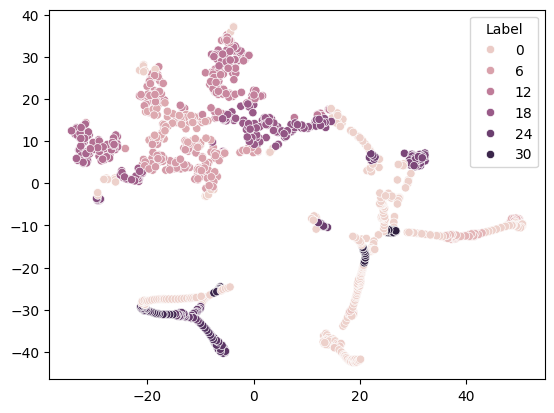

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 X와 레이블 y를 사용한다고 가정
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df1[['latitude', 'longitude']])

sns.set_palette("deep")
sns.scatterplot(x = X_tsne[:, 0], y = X_tsne[:, 1], hue=df1['labels'])
plt.legend(title='Label')
plt.show()


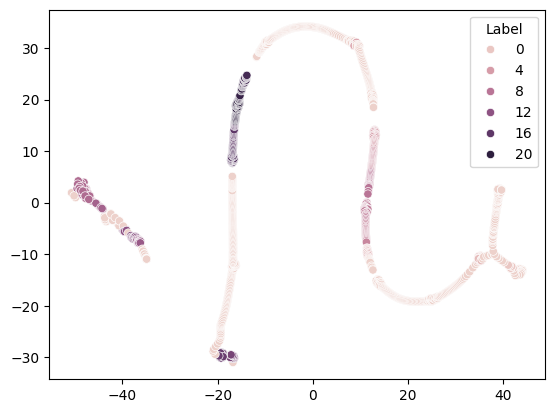

In [28]:
# 데이터 X와 레이블 y를 사용한다고 가정
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df2[['latitude', 'longitude']])

sns.set_palette("deep")
sns.scatterplot(x = X_tsne[:, 0], y = X_tsne[:, 1], hue=df2['labels'])
plt.legend(title='Label')
plt.show()

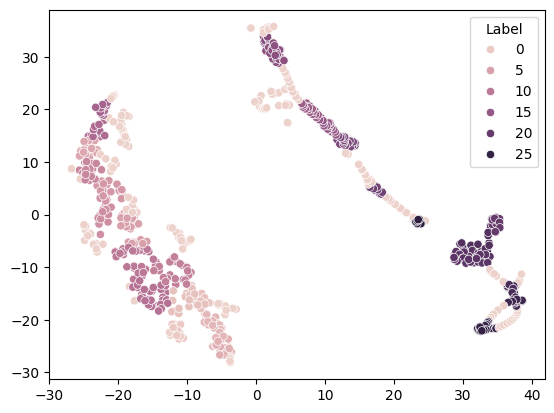

In [29]:
# 데이터 X와 레이블 y를 사용한다고 가정
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df3[['latitude', 'longitude']])

sns.set_palette("deep")
sns.scatterplot(x = X_tsne[:, 0], y = X_tsne[:, 1], hue=df3['labels'])
plt.legend(title='Label')
plt.show()

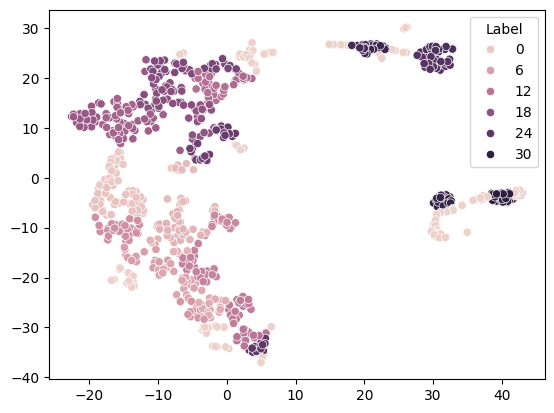

In [30]:
# 데이터 X와 레이블 y를 사용한다고 가정
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df4[['latitude', 'longitude']])

sns.set_palette("deep")
sns.scatterplot(x = X_tsne[:, 0], y = X_tsne[:, 1], hue=df4['labels'])
plt.legend(title='Label')
plt.show()

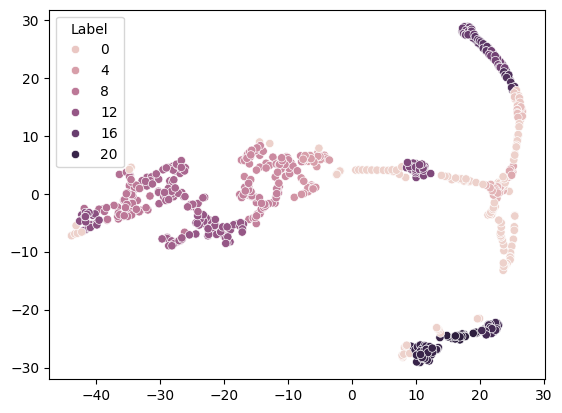

In [31]:
# 데이터 X와 레이블 y를 사용한다고 가정
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df5[['latitude', 'longitude']])

sns.set_palette("deep")
sns.scatterplot(x = X_tsne[:, 0], y = X_tsne[:, 1], hue=df5['labels'])
plt.legend(title='Label')
plt.show()